## Importing required Python Packages and Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
#from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
!pip install pyramid-arima
from pyramid.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
std=StandardScaler()
#pd.set_option('display.float_format', lambda x: '%.6f' % x)

     |████████████████████████████████| 604kB 2.7MB/s 


In [ ]:
covid=pd.read_csv("/content/covid_19_clean_complete (2).csv")
covid.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0.0,0,0.0,Eastern Mediterranean
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0.0,0,0.0,Europe
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0.0,0,0.0,Africa
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0.0,0,0.0,Europe
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0.0,0,0.0,Africa


In [ ]:
print("Size/Shape of the dataset: ",covid.shape)
print("Checking for null values:\n",covid.isnull().sum())
print("Checking Data-type of each column:\n",covid.dtypes)

Size/Shape of the dataset:  (36279, 10)
Checking for null values:
 Province/State    25437
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
Active                0
WHO Region            0
dtype: int64
Checking Data-type of each column:
 Province/State     object
Country/Region     object
Lat               float64
Long              float64
Date               object
Confirmed           int64
Deaths            float64
Recovered           int64
Active            float64
WHO Region         object
dtype: object


In [ ]:
#Dropping column "Province/State" as it contains too many missing values
covid.drop(1,inplace=True)

In [ ]:
#Converting "Date" into Datetime format
covid["Date"]=pd.to_datetime(covid["Date"])

## Datewise analysis 

In [ ]:
#Grouping different types of cases as per the date
datewise=covid.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum',"Active":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()
datewise.head()

,Confirmed,Recovered,Deaths,Active,Days Since
Date,,,,,
2020-01-22,555,28,17.0,510.0,0 days
2020-01-23,654,30,18.0,606.0,1 days
2020-01-24,941,35,25.0,881.0,2 days
2020-01-25,1434,38,41.0,1355.0,3 days
2020-01-26,2118,51,53.0,2014.0,4 days


In [ ]:
print("Basic Information")
print("Totol number of countries with Disease Spread: ",len(covid["Country/Region"].unique()))
print("Total number of Confirmed Cases around the World: ",datewise["Confirmed"].iloc[-1])
print("Total number of Recovered Cases around the World: ",datewise["Recovered"].iloc[-1])
print("Total number of Deaths Cases around the World: ",datewise["Deaths"].iloc[-1])
print("Total number of Active Cases around the World: ",(datewise["Active"].iloc[-1]))
print("Total number of Closed Cases around the World: ",datewise["Recovered"].iloc[-1]+datewise["Deaths"].iloc[-1])
print("Approximate number of Confirmed Cases per Day around the World: ",np.round(datewise["Confirmed"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Recovered Cases per Day around the World: ",np.round(datewise["Recovered"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Death Cases per Day around the World: ",np.round(datewise["Deaths"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Confirmed Cases per hour around the World: ",np.round(datewise["Confirmed"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Recovered Cases per hour around the World: ",np.round(datewise["Recovered"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Death Cases per hour around the World: ",np.round(datewise["Deaths"].iloc[-1]/((datewise.shape[0])*24)))
print("Number of Confirmed Cases in last 24 hours: ",datewise["Confirmed"].iloc[-1]-datewise["Confirmed"].iloc[-2])
print("Number of Recovered Cases in last 24 hours: ",datewise["Recovered"].iloc[-1]-datewise["Recovered"].iloc[-2])
print("Number of Death Cases in last 24 hours: ",datewise["Deaths"].iloc[-1]-datewise["Deaths"].iloc[-2])

Basic Information
Totol number of countries with Disease Spread:  187
Total number of Confirmed Cases around the World:  7117730
Total number of Recovered Cases around the World:  3219572
Total number of Deaths Cases around the World:  405681.0
Total number of Active Cases around the World:  3492477.0
Total number of Closed Cases around the World:  3625253.0
Approximate number of Confirmed Cases per Day around the World:  51207.0
Approximate number of Recovered Cases per Day around the World:  23162.0
Approximate number of Death Cases per Day around the World:  2919.0
Approximate number of Confirmed Cases per hour around the World:  2134.0
Approximate number of Recovered Cases per hour around the World:  965.0
Approximate number of Death Cases per hour around the World:  122.0
Number of Confirmed Cases in last 24 hours:  108122
Number of Recovered Cases in last 24 hours:  151597
Number of Death Cases in last 24 hours:  3792.0


In [ ]:
fig=px.bar(x=datewise.index,y=datewise["Active"])
fig.update_layout(title="Distribution of Number of Active Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

In [ ]:
print("Average increase in number of Confirmed Cases every day: ",np.round(datewise["Confirmed"].diff().fillna(0).mean()))
print("Average increase in number of Recovered Cases every day: ",np.round(datewise["Recovered"].diff().fillna(0).mean()))
print("Average increase in number of Deaths Cases every day: ",np.round(datewise["Deaths"].diff().fillna(0).mean()))

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"].diff().fillna(0),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"].diff().fillna(0),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"].diff().fillna(0),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Daily increase in different types of Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Average increase in number of Confirmed Cases every day:  51203.0
Average increase in number of Recovered Cases every day:  23162.0
Average increase in number of Deaths Cases every day:  2918.0


In [ ]:
#Growth rate of Confirmed, Recovered and Death Cases
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
#Calculating the Mortality Rate and Recovery Rate
datewise["Mortality Rate"]=(datewise["Deaths"]/datewise["Confirmed"])*100
datewise["Recovery Rate"]=(datewise["Recovered"]/datewise["Confirmed"])*100
datewise["Active Cases"]=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"]
datewise["Closed Cases"]=datewise["Recovered"]+datewise["Deaths"]

print("Average Mortality Rate",datewise["Mortality Rate"].mean())
print("Median Mortality Rate",datewise["Mortality Rate"].median())
print("Average Recovery Rate",datewise["Recovery Rate"].mean())
print("Median Recovery Rate",datewise["Recovery Rate"].median())

#Plotting Mortality and Recovery Rate 
fig = make_subplots(rows=2, cols=1,
                   subplot_titles=("Recovery Rate", "Mortatlity Rate"))
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Recovered"]/datewise["Confirmed"])*100,name="Recovery Rate"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Deaths"]/datewise["Confirmed"])*100,name="Mortality Rate"),
    row=2, col=1
)
fig.update_layout(height=1000,legend=dict(x=-0.1,y=1.2,traceorder="normal"))
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Recovery Rate", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2)
fig.update_yaxes(title_text="Mortality Rate", row=1, col=2)
fig.show()

Average Mortality Rate 4.872411538641936
Median Mortality Rate 5.152173989153686
Average Recovery Rate 28.05850906198117
Median Recovery Rate 28.34518297814135


### Countrywise Analysis

In [ ]:
top = covid[covid['Date'] == covid['Date'].max()]
world = top.groupby('Country/Region')['Confirmed','Active','Deaths'].sum().reset_index()
world.head()
figure = px.choropleth(world,locations="Country/Region",locationmode='country names' 
                     ,color="Active",hover_name="Country/Region",range_color=[1,300000],
                      title="Countries with Active Cases")
figure.show()

In [ ]:
#Calculating countrywise Moratality and Recovery Rate
countrywise=covid[covid["Date"]==covid["Date"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Active":"sum","Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

In [ ]:
countrywise.head(10)

,Confirmed,Recovered,Active,Deaths,Mortality,Recovery
Country/Region,,,,,,
US,1960897,518522,1331385.0,110990.0,5.660165,26.443102
Brazil,707412,378257,292021.0,37134.0,5.249275,53.470538
Russia,476043,230226,239854.0,5963.0,1.252618,48.362438
United Kingdom,288834,1255,246900.0,40679.0,14.083868,0.434506
India,265928,129095,129360.0,7473.0,2.810159,48.545095
Spain,241717,150376,64205.0,27136.0,11.226351,62.211595
Italy,235278,166584,34730.0,33964.0,14.435689,70.803050
Peru,199696,89556,104569.0,5571.0,2.789740,44.846166
France,191313,71182,90919.0,29212.0,15.269219,37.207090


#### Proportion of Countries in Confirmed, Recovered,Active and Death Cases 

Text(0.5, 1.0, 'Top 15 countries as per Number of Death Cases')

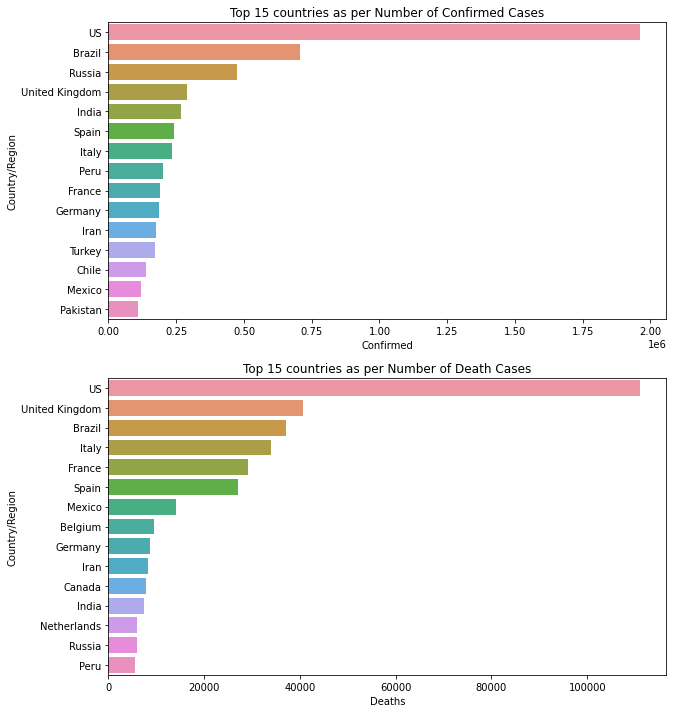

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,12))
top_15_confirmed=countrywise.sort_values(["Confirmed"],ascending=False).head(15)
top_15_deaths=countrywise.sort_values(["Deaths"],ascending=False).head(15)
sns.barplot(x=top_15_confirmed["Confirmed"],y=top_15_confirmed.index,ax=ax1)
ax1.set_title("Top 15 countries as per Number of Confirmed Cases")
sns.barplot(x=top_15_deaths["Deaths"],y=top_15_deaths.index,ax=ax2)
ax2.set_title("Top 15 countries as per Number of Death Cases")

Text(0.5, 1.0, 'Top 15 Countries with Most Number of Closed Cases')

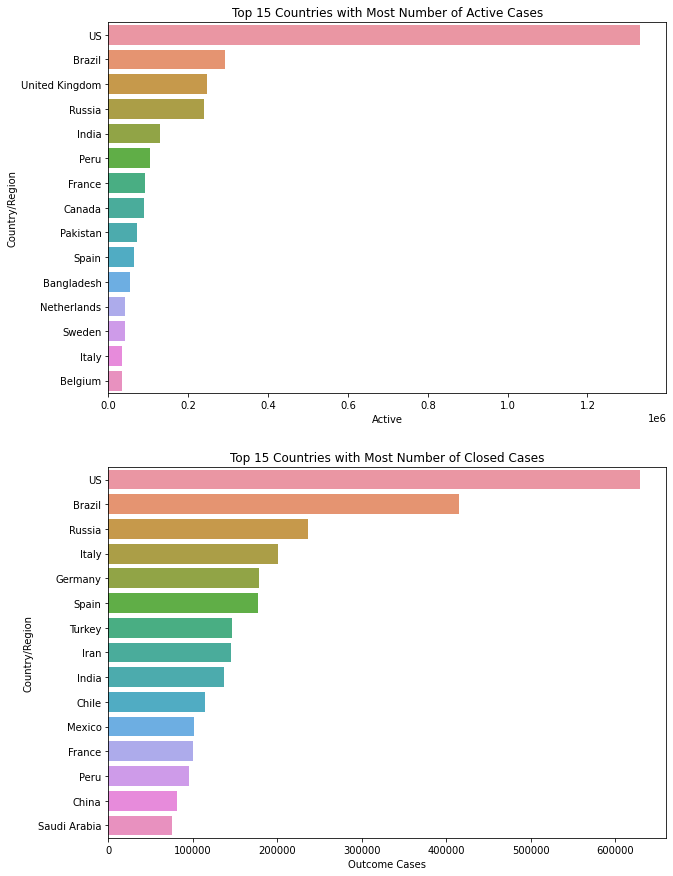

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
countrywise["Outcome Cases"]=(countrywise["Recovered"]+countrywise["Deaths"])
top_15_active=countrywise.sort_values(["Active"],ascending=False).head(15)
top_15_outcome=countrywise.sort_values(["Outcome Cases"],ascending=False).head(15)
sns.barplot(x=top_15_active["Active"],y=top_15_active.index,ax=ax1)
sns.barplot(x=top_15_outcome["Outcome Cases"],y=top_15_outcome.index,ax=ax2)
ax1.set_title("Top 15 Countries with Most Number of Active Cases")
ax2.set_title("Top 15 Countries with Most Number of Closed Cases")

#### Comparison of China, Italy, US, Spain, Brazil and Rest of the World

In [ ]:
china_data=covid[covid["Country/Region"]=="Mainland China"]
Italy_data=covid[covid["Country/Region"]=="Italy"]
US_data=covid[covid["Country/Region"]=="US"]
spain_data=covid[covid["Country/Region"]=="Spain"]
brazil_data=covid[covid["Country/Region"]=="Brazil"]
rest_of_world=covid[(covid["Country/Region"]!="Mainland China")&(covid["Country/Region"]!="Italy")&(covid["Country/Region"]!="US")&(covid["Country/Region"]!="Spain")&(covid["Country/Region"]!="Brazil")]

datewise_china=china_data.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Italy=Italy_data.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_US=US_data.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Spain=spain_data.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Brazil=brazil_data.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_restofworld=rest_of_world.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Confirmed"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Confirmed"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Confirmed"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Confirmed"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Confirmed"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Confirmed"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Confirmed Cases plot",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Deaths"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Deaths"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Deaths"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Deaths"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Deaths"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Deaths"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Death Cases plot",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
datewise_china["Mortality"]=(datewise_china["Deaths"]/datewise_china["Confirmed"])*100
datewise_Italy["Mortality"]=(datewise_Italy["Deaths"]/datewise_Italy["Confirmed"])*100
datewise_US["Mortality"]=(datewise_US["Deaths"]/datewise_US["Confirmed"])*100
datewise_Spain["Mortality"]=(datewise_Spain["Deaths"]/datewise_Spain["Confirmed"])*100
datewise_Brazil["Mortality"]=(datewise_Brazil["Deaths"]/datewise_Brazil["Confirmed"])*100
datewise_restofworld["Mortality"]=(datewise_restofworld["Deaths"]/datewise_restofworld["Confirmed"])*100

datewise_china["Recovery"]=(datewise_china["Recovered"]/datewise_china["Confirmed"])*100
datewise_Italy["Recovery"]=(datewise_Italy["Recovered"]/datewise_Italy["Confirmed"])*100
datewise_US["Recovery"]=(datewise_US["Recovered"]/datewise_US["Confirmed"])*100
datewise_Spain["Recovery"]=(datewise_Spain["Recovered"]/datewise_Spain["Confirmed"])*100
datewise_Brazil["Recovery"]=(datewise_Brazil["Recovered"]/datewise_Brazil["Confirmed"])*100
datewise_restofworld["Recovery"]=(datewise_restofworld["Recovered"]/datewise_restofworld["Confirmed"])*100

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Mortality"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Mortality"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Mortality"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Mortality"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Mortality"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Mortality"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Mortality Rate comparison plot",
                  xaxis_title="Date",yaxis_title="Mortality Rate",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

## Data Analysis for India 

In [ ]:
india_data=covid[covid["Country/Region"]=="India"]
datewise_india=india_data.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
print(datewise_india.iloc[-1])
print("Total Active Cases: ",datewise_india["Confirmed"].iloc[-1]-datewise_india["Recovered"].iloc[-1]-datewise_india["Deaths"].iloc[-1])
print("Total Closed Cases: ",datewise_india["Recovered"].iloc[-1]+datewise_india["Deaths"].iloc[-1])

Confirmed    265928.0
Recovered    129095.0
Deaths         7473.0
Name: 2020-06-08 00:00:00, dtype: float64
Total Active Cases:  129360.0
Total Closed Cases:  136568.0


In [ ]:
datewise_india.head()

,Confirmed,Recovered,Deaths,WeekOfYear
Date,,,,
2020-01-22,0,0,0.000000,4
2020-01-23,0,0,0.000000,4
2020-01-24,0,0,0.000000,4
2020-01-25,0,0,0.000000,4
2020-01-26,0,0,0.000000,4


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Deaths"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases in India",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Confirmed"].diff().fillna(0),
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Recovered"].diff().fillna(0),
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Deaths"].diff().fillna(0),
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Daily increase in different types of cases in India",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:

datewise_india["WeekOfYear"]=datewise_india.index.weekofyear

week_num_india=[]
india_weekwise_confirmed=[]
india_weekwise_recovered=[]
india_weekwise_deaths=[]
w=1
for i in list(datewise_india["WeekOfYear"].unique()):
    india_weekwise_confirmed.append(datewise_india[datewise_india["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    india_weekwise_recovered.append(datewise_india[datewise_india["WeekOfYear"]==i]["Recovered"].iloc[-1])
    india_weekwise_deaths.append(datewise_india[datewise_india["WeekOfYear"]==i]["Deaths"].iloc[-1])
    week_num_india.append(w)
    w=w+1
    
fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num_india, y=india_weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num_india, y=india_weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num_india, y=india_weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases in India",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Text(0.5, 1.0, "India's Weekwise increase in Number of Death Cases")

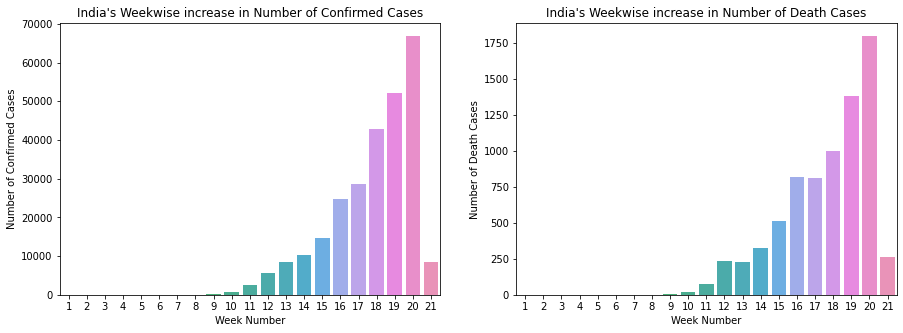

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.barplot(x=week_num_india,y=pd.Series(india_weekwise_confirmed).diff().fillna(0),ax=ax1)
sns.barplot(x=week_num_india,y=pd.Series(india_weekwise_deaths).diff().fillna(0),ax=ax2)
ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Death Cases")
ax1.set_title("India's Weekwise increase in Number of Confirmed Cases")
ax2.set_title("India's Weekwise increase in Number of Death Cases")

## Prediction using Machine Learning Models

#### Linear Regression Model for Confirm Cases Prediction

In [ ]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [ ]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [ ]:
lin_reg=LinearRegression(normalize=True)

In [ ]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  1771565.4799564534


In [ ]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

#### Polynomial Regression for Prediction of Confirmed Cases

In [ ]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [ ]:
poly = PolynomialFeatures(degree = 7) 

In [ ]:
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["Confirmed"]

In [ ]:
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  94641.24831190577


In [ ]:
comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [ ]:
new_prediction_poly=[]
for i in range(1,18):
    new_date_poly=poly.fit_transform(np.array(datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

#### Support Vector Machine ModelRegressor for Prediction of Confirmed Cases 

In [ ]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [ ]:
#Intializing SVR Model
svm=SVR(C=1,degree=5,kernel='poly',epsilon=0.01)

In [ ]:
#Fitting model on the training data
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

SVR(C=1, cache_size=200, coef0=0.0, degree=5, epsilon=0.01, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))

Root Mean Square Error for Support Vectore Machine:  502297.64984681306


In [ ]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [ ]:
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]
for i in range(1,18):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [ ]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly,new_prediction_svm),
                               columns=["Dates","Linear Regression Prediction","Polynonmial Regression Prediction","SVM Prediction"])
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction
0,2020-06-09,5181630.962867,7427279.374399,7188995.173799
1,2020-06-10,5228976.782502,7581189.810178,7434168.148184
2,2020-06-11,5276322.602137,7737242.478194,7686447.033904
3,2020-06-12,5323668.421772,7895074.507900,7945985.188099
4,2020-06-13,5371014.241407,8054263.512627,8212938.158670


## Time Series Forecasting 

### ARIMA Model (using AUTOARIMA)

In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [ ]:
model_arima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=2,max_q=2,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Confirmed"])

Fit ARIMA: order=(1, 2, 1); AIC=2660.962, BIC=2672.432, Fit time=0.195 seconds
Fit ARIMA: order=(1, 2, 2); AIC=2661.930, BIC=2676.267, Fit time=0.190 seconds
Fit ARIMA: order=(2, 2, 1); AIC=2660.823, BIC=2675.161, Fit time=0.196 seconds
Fit ARIMA: order=(2, 2, 2); AIC=2626.603, BIC=2643.808, Fit time=0.357 seconds
Total fit time: 0.944 seconds


ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 2, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={}, seasonal_order=None,
      solver='lbfgs', start_params=None, suppress_warnings=True,
      transparams=True, trend='c')

In [ ]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  12060.85769102293


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
ARIMA_model_new_prediction=[]
for i in range(1,18):
    ARIMA_model_new_prediction.append(model_arima.predict(len(valid)+i)[-1])
model_predictions["ARIMA Model Prediction"]=ARIMA_model_new_prediction
model_predictions


,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,ARIMA Model Prediction
0,2020-06-09,5181630.962867,7427279.374399,7188995.173799,7218339.662599
1,2020-06-10,5228976.782502,7581189.810178,7434168.148184,7339276.133529
2,2020-06-11,5276322.602137,7737242.478194,7686447.033904,7471023.866086
3,2020-06-12,5323668.421772,7895074.507900,7945985.188099,7608218.019589
4,2020-06-13,5371014.241407,8054263.512627,8212938.158670,7742809.361128
5,2020-06-14,5418360.061042,8214323.400409,8487463.699817,7869589.627500
6,2020-06-15,5465705.880677,8374700.033152,8769721.787574,7989466.905274
7,2020-06-16,5513051.700312,8534766.731829,9059874.635348,8108461.548272
8,2020-06-17,5560397.519947,8693819.625366,9358086.709458,8233370.215408
9,2020-06-18,5607743.339582,8851072.840884,9664524.744668,8367197.937399


### Facebook's Prophet Model for forecasting 

In [ ]:
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(datewise.index),list(datewise["Confirmed"])),columns=['ds','y'])

In [ ]:
prophet_c.fit(prophet_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast_c=prophet_c.make_future_dataframe(periods=17)
forecast_confirmed=forecast_c.copy()

In [ ]:
confirmed_forecast=prophet_c.predict(forecast_c)
#print(confirmed_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))

Root Mean Squared Error for Prophet Model:  26202.109236655695


Figure(720x432)


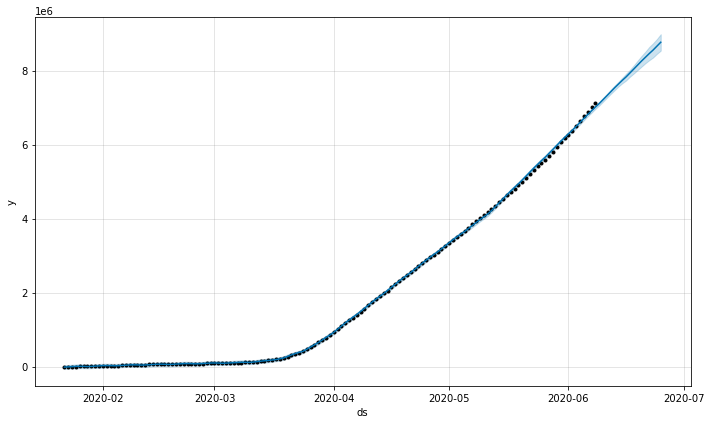

In [ ]:
print(prophet_c.plot(confirmed_forecast))

Figure(648x432)


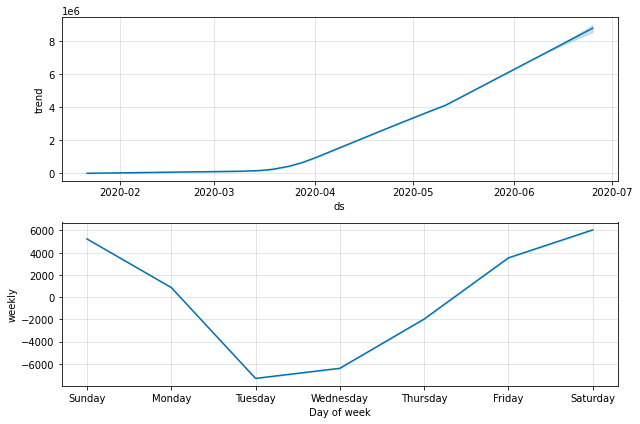

In [ ]:
print(prophet_c.plot_components(confirmed_forecast))

## Summarization of Forecasts using different Models

In [ ]:
model_names=["Linear Regression","Polynomial Regression","Support Vector Machine Regressor","ARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
3,ARIMA Model,12060.857691
4,Facebook's Prophet Model,26202.109237
1,Polynomial Regression,94641.248312
2,Support Vector Machine Regressor,502297.649847
0,Linear Regression,1771565.479956


In [ ]:
model_predictions["Prophet's Prediction"]=list(confirmed_forecast["yhat"].tail(17))
model_predictions["Prophet's Upper Bound"]=list(confirmed_forecast["yhat_upper"].tail(17))
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,ARIMA Model Prediction,Prophet's Prediction,Prophet's Upper Bound
0,2020-06-09,5181630.962867,7427279.374399,7188995.173799,7218339.662599,7106477.060985,7154676.072813
1,2020-06-10,5228976.782502,7581189.810178,7434168.148184,7339276.133529,7210700.827235,7263035.391262
2,2020-06-11,5276322.602137,7737242.478194,7686447.033904,7471023.866086,7318446.401395,7369088.321119
3,2020-06-12,5323668.421772,7895074.507900,7945985.188099,7608218.019589,7427271.208163,7482218.744307
4,2020-06-13,5371014.241407,8054263.512627,8212938.158670,7742809.361128,7533104.846355,7592242.520305


## Time Series Forecasting for Death Cases

In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [ ]:
model_arima_deaths=auto_arima(model_train["Deaths"],trace=True, error_action='ignore', start_p=0,start_q=0,
                              max_p=3,max_q=3,suppress_warnings=True,stepwise=False,seasonal=False)     
model_arima_deaths.fit(model_train["Deaths"])

Fit ARIMA: order=(0, 2, 0); AIC=2107.738, BIC=2113.473, Fit time=0.004 seconds
Fit ARIMA: order=(0, 2, 1); AIC=2109.706, BIC=2118.309, Fit time=0.020 seconds
Fit ARIMA: order=(0, 2, 2); AIC=2094.824, BIC=2106.294, Fit time=0.060 seconds
Fit ARIMA: order=(0, 2, 3); AIC=2094.860, BIC=2109.198, Fit time=0.101 seconds
Fit ARIMA: order=(1, 2, 0); AIC=2109.722, BIC=2118.325, Fit time=0.076 seconds
Fit ARIMA: order=(1, 2, 1); AIC=2102.387, BIC=2113.857, Fit time=0.110 seconds
Fit ARIMA: order=(1, 2, 2); AIC=2095.454, BIC=2109.792, Fit time=0.166 seconds
Fit ARIMA: order=(1, 2, 3); AIC=2077.890, BIC=2095.095, Fit time=0.233 seconds
Fit ARIMA: order=(2, 2, 0); AIC=2102.614, BIC=2114.084, Fit time=0.059 seconds
Fit ARIMA: order=(2, 2, 1); AIC=2091.587, BIC=2105.925, Fit time=0.110 seconds
Fit ARIMA: order=(2, 2, 2); AIC=2055.501, BIC=2072.706, Fit time=0.212 seconds
Fit ARIMA: order=(2, 2, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 2, 0); AIC=2100.869, BIC=2115.207, Fit time

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 2, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={}, seasonal_order=None,
      solver='lbfgs', start_params=None, suppress_warnings=True,
      transparams=True, trend='c')

In [ ]:
predictions_deaths=model_arima_deaths.predict(len(valid))
y_pred["ARIMA Death Prediction"]=predictions_deaths

In [ ]:
print("Root Mean Square Error: ",np.sqrt(mean_squared_error(valid["Deaths"],predictions_deaths)))

Root Mean Square Error:  823.1951450210544


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Deaths"],
                    mode='lines+markers',name="Train Data for Death Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Deaths"],
                    mode='lines+markers',name="Validation Data for Death Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Death Prediction"],
                    mode='lines+markers',name="Prediction for Death Cases",))
fig.update_layout(title="Death Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
ARIMA_model_death_forecast=[]
for i in range(1,18):
    ARIMA_model_death_forecast.append(model_arima_deaths.predict(len(valid)+i)[-1])

In [ ]:
pd.DataFrame(zip(new_date,ARIMA_model_death_forecast),columns=["Date","ARIMA Model Death Forecast"]).head()

,Date,ARIMA Model Death Forecast
0,2020-06-09,411093.147521
1,2020-06-10,416156.011796
2,2020-06-11,421627.891753
3,2020-06-12,426965.662262
4,2020-06-13,431780.416759


# Forecasting for India

## Forecasting for Confirmed cases in India

In [ ]:
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(datewise_india.index),list(datewise_india["Confirmed"])),columns=['ds','y'])

In [ ]:
prophet_c.fit(prophet_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast_c=prophet_c.make_future_dataframe(periods=17)
forecast_confirmed=forecast_c.copy()

In [ ]:
confirmed_forecast=prophet_c.predict(forecast_c)
print(confirmed_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])

            ds          yhat    yhat_lower    yhat_upper
0   2020-01-22   -563.379209  -8518.342979   6723.469601
1   2020-01-23   -459.962861  -8919.302799   7665.625082
2   2020-01-24   -385.313759  -7767.648381   7035.411760
3   2020-01-25   -145.642120  -7682.957516   7265.111278
4   2020-01-26    256.151785  -7944.163321   7606.179605
..         ...           ...           ...           ...
151 2020-06-21 334355.676544 321882.543760 347029.524182
152 2020-06-22 341205.517755 327974.318683 354457.134628
153 2020-06-23 346827.964618 332892.636435 360789.511612
154 2020-06-24 353572.730683 338764.559824 368969.551204
155 2020-06-25 360336.135590 344863.877594 375341.507264

[156 rows x 4 columns]


In [ ]:
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise_india["Confirmed"],confirmed_forecast['yhat'].head(datewise_india.shape[0]))))

Root Mean Squared Error for Prophet Model:  4090.843582540386


Figure(720x432)


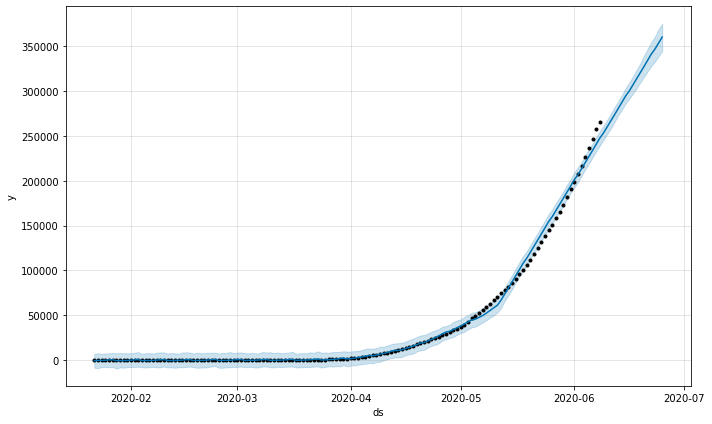

In [ ]:
print(prophet_c.plot(confirmed_forecast))

Figure(648x432)


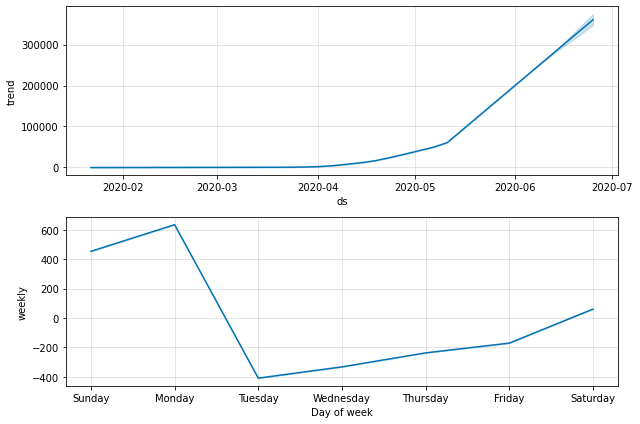

In [ ]:
print(prophet_c.plot_components(confirmed_forecast))

## Forecasting for Recovered Cases in India

In [ ]:
prophet_r=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_rec=pd.DataFrame(zip(list(datewise_india.index),list(datewise_india["Recovered"])),columns=['ds','y'])

In [ ]:
prophet_r.fit(prophet_rec)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast_r=prophet_r.make_future_dataframe(periods=17)
forecast_rec=forecast_r.copy()

In [ ]:
rec_forecast=prophet_r.predict(forecast_r)
print(rec_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])

            ds          yhat    yhat_lower    yhat_upper
0   2020-01-22   -408.656938  -5251.018273   4318.518813
1   2020-01-23   -458.690980  -5455.650231   4535.013689
2   2020-01-24    -70.702173  -5057.555587   4591.100571
3   2020-01-25     38.940728  -4862.064167   4861.405494
4   2020-01-26    150.710545  -4822.764640   5278.988220
..         ...           ...           ...           ...
151 2020-06-21 166681.705206 159696.105089 173138.759062
152 2020-06-22 170356.923890 163026.256730 177789.467234
153 2020-06-23 173459.856298 165794.017695 181431.104763
154 2020-06-24 177025.537940 169298.138025 185053.965795
155 2020-06-25 180600.684201 171989.082398 189539.779190

[156 rows x 4 columns]


In [ ]:
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise_india["Recovered"],rec_forecast['yhat'].head(datewise_india.shape[0]))))

Root Mean Squared Error for Prophet Model:  2527.983397019272


Figure(720x432)


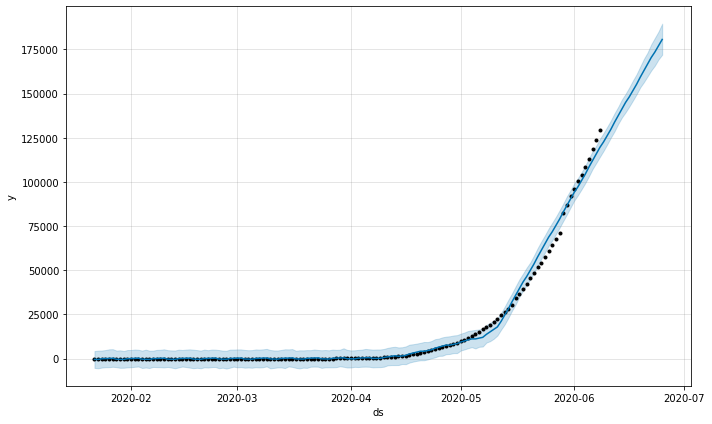

In [ ]:
print(prophet_r.plot(rec_forecast))

## Forecasting for Death Cases in India

In [ ]:
prophet_d=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_death=pd.DataFrame(zip(list(datewise_india.index),list(datewise_india["Deaths"])),columns=['ds','y'])

In [ ]:
prophet_d.fit(prophet_death)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast_d=prophet_d.make_future_dataframe(periods=17)
forecast_death=forecast_d.copy()

In [ ]:
death_forecast=prophet_d.predict(forecast_d)
print(death_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])

            ds        yhat  yhat_lower   yhat_upper
0   2020-01-22  -18.510309 -251.801365   202.784847
1   2020-01-23  -14.995296 -257.270486   201.851757
2   2020-01-24  -10.435063 -221.095275   228.979750
3   2020-01-25   -4.688738 -226.389254   227.376224
4   2020-01-26    1.462258 -233.972543   236.392841
..         ...         ...         ...          ...
151 2020-06-21 9156.431152 8834.215888  9496.353594
152 2020-06-22 9336.359768 8998.433665  9671.736495
153 2020-06-23 9480.866618 9146.384158  9856.456699
154 2020-06-24 9656.287115 9259.508651 10030.722651
155 2020-06-25 9832.333130 9405.651289 10261.159498

[156 rows x 4 columns]


In [ ]:
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise_india["Deaths"],death_forecast['yhat'].head(datewise_india.shape[0]))))

Root Mean Squared Error for Prophet Model:  117.90228552301707


Figure(720x432)


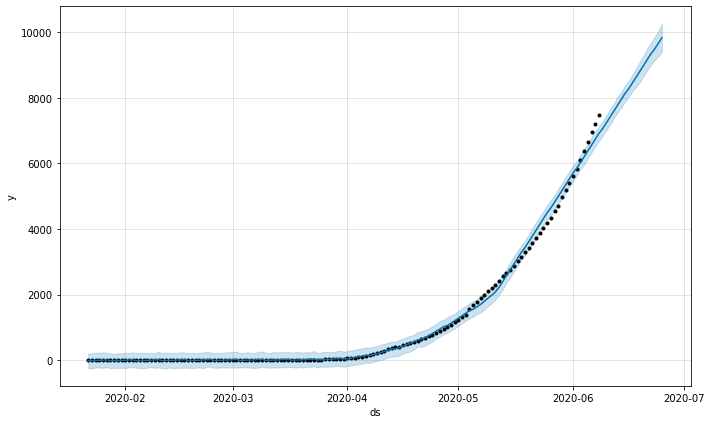

In [ ]:
print(prophet_d.plot(death_forecast))